In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


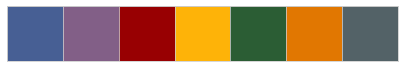

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

> **GIVEN TARGET**

I will start with analyzing the unmodified dataset.

In [6]:
# observe dimensionality of dataset
df.shape

(11693, 28)

There are 27 independent variables.

In [7]:
# observe feature names
df.columns

Index(['actor_value', 'budget', 'age', 'gender', 'order', 'popularity',
       'release_date', 'runtime', 'usa', 'vote_average', 'vote_count',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'thriller', 'war', 'western'],
      dtype='object')

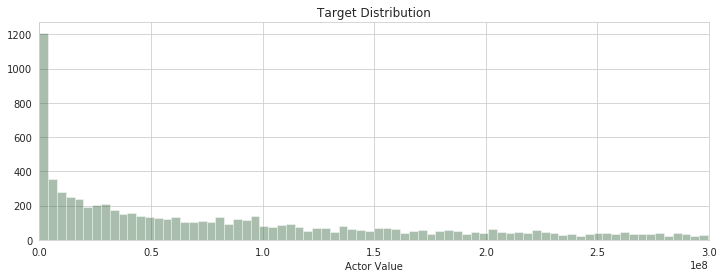

In [8]:
# plot target distribution up to $300,000,000

plt.xlim(0, 3e8)

sns.distplot(df['actor_value'], bins=5000, color=mp.colors(4), 
             axlabel='Actor Value', kde=False)

plt.title('Target Distribution');

In [9]:
# separate data into features and target for given target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

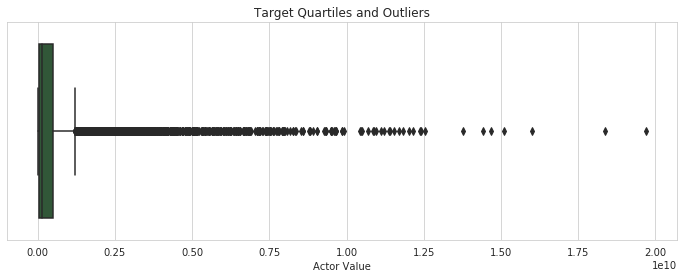

In [10]:
# plot target quartiles and outliers

sns.boxplot(y, color=mp.colors(4))

plt.xlabel('Actor Value')
plt.title('Target Quartiles and Outliers');

In [11]:
# get statistics for target
y.describe()

count    1.169300e+04
mean     5.647359e+08
std      1.243346e+09
min      1.238841e+00
25%      3.130126e+07
50%      1.396449e+08
75%      5.060413e+08
max      1.970652e+10
Name: actor_value, dtype: float64

First, I will split the data to create a holdout set for validation.

In [12]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

I will observe the out of the box Random Forest Regressor model.

In [13]:
def get_base_model(features, target):
    """Return base random forest regressor model"""
    model = RandomForestRegressor(random_state=27)
    model.fit(features, target)
    
    return model

In [14]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='full_target').drop(
        ['bootstrap', 'ccp_alpha', 'criterion', 'max_leaf_nodes', 'max_samples', 
        'min_impurity_decrease', 'min_impurity_split', 'min_weight_fraction_leaf', 
        'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [15]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [16]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: {results_range[0]:.4f}, {results_range[1]:.4f}'

In [17]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.9021, Range: 0.8573, 0.9307'

In [18]:
def get_cv_rmse(features, target, model):
    """Return CV average root mean squared error and root mean square error range"""
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    global results
    results = np.round(np.sqrt(cv_results * -1), 5)
    results_range = (np.min(results), np.max(results))
    ave_result = np.round(np.sqrt(np.mean(cv_results) * -1), 5)
        
    return f'Average RMSE: ${ave_result:,.2f}, Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [19]:
# get cross-validation results
get_cv_rmse(X_train, y_train, base_model)

'Average RMSE: $382,362,189.85, Range: ($316,454,991.41, $489,382,853.39)'

In [20]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

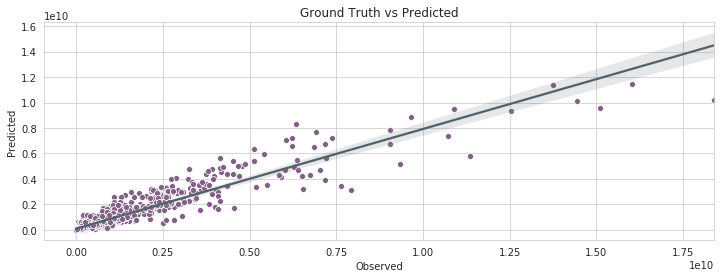

In [21]:
# plot observed target vs. predictions for out of the box rfr model
plot_predictions(X, y, base_model)

In [22]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals");

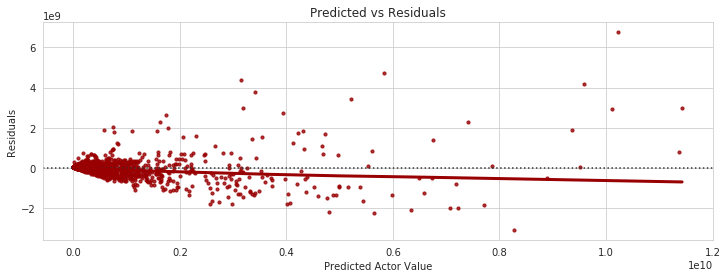

In [23]:
# plot predictions vs. residuals for out of the box rfr model
plot_residuals(X, y, base_model)

In [24]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals')

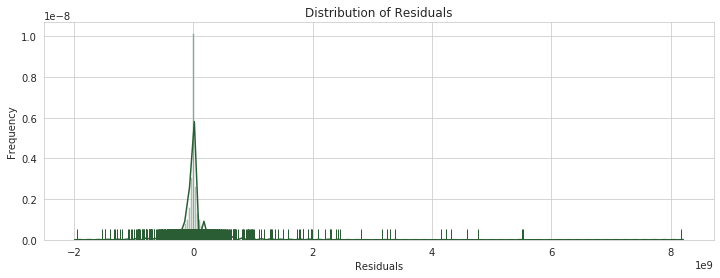

In [25]:
# plot residuals distribution for out of the box rfr model
plot_residual_distribution(X, y, base_model)

> **RANDOM GRID SEARCH**

I will use a random grid search to tune the hyperparameters.

In [26]:
# create initial parameter search grid
random_grid_1 = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(600, 2400, num=10)]}
random_grid_1

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]}

In [27]:
def get_best_model(train_features, train_target, grid):
    """Return best model for randomized hyperparameter grid search"""
    # instantiate model
    rfr = RandomForestRegressor(random_state=27)
    # instantiate grid search model
    rfr_random = RandomizedSearchCV(
        estimator=rfr, param_distributions=grid, n_iter=100, cv=3, 
        scoring='neg_root_mean_squared_error', verbose=1, 
        random_state=27, n_jobs=-1, return_train_score=True)
    # fit search model
    rfr_random.fit(train_features, train_target)
    # get best model
    best_model = rfr_random.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        rfr_random.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [28]:
# get 1st best model and results
best_model_1, results_1 = get_best_model(X_train, y_train, random_grid_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


In [29]:
# get parameters
get_params(best_model_1)

max_depth            None
max_features            9
min_samples_leaf        1
min_samples_split       5
n_estimators         2000
Name: full_target, dtype: object

In [30]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, best_model_1)

'Average Adjusted R2 Score: 0.8990, Range: 0.8493, 0.9325'

In [31]:
# get statistics for 10 fold cross-validation
get_cv_rmse(X_train, y_train, best_model_1)

'Average RMSE: $388,569,921.57, Range: ($316,300,389.74, $502,892,694.00)'

In [32]:
def get_results(results):
    # remove annoying prefix
    new_cols = [i[i.startswith('param_') and len('param_'):] 
                for i 
                in results.columns.to_list()]
    my_results = results.rename(dict(zip(results.columns, new_cols)), axis=1)
    # rename index
    my_results.index.names = ['rank']
    # set columns to return
    slices = [13, 18, 8, 7, 6, 5, 4]
    
    return my_results.head(15).iloc[:, slices]

In [33]:
# get grid results
get_results(results_1)

,mean_test_score,mean_train_score,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
rank,,,,,,,
1,-4.017443e+08,-1.876346e+08,None,9,1,5,2000
2,-4.081092e+08,-1.654491e+08,80,7,1,3,1800
3,-4.087273e+08,-2.249722e+08,50,8,1,8,1000
4,-4.095273e+08,-2.238612e+08,100,9,2,5,1800
5,-4.126190e+08,-2.563123e+08,20,10,3,6,600
6,-4.133569e+08,-2.283407e+08,40,8,2,5,2400
7,-4.141237e+08,-2.305967e+08,70,7,1,8,1800
8,-4.151296e+08,-2.399869e+08,100,7,1,9,1600
9,-4.179562e+08,-2.902030e+08,40,10,4,5,2400


In [34]:
def plot_results_param(parameter, results):
    """Returns plot of average train and test scores for random parameter"""
    plt.plot(results['param_' + parameter].sort_values(), 
             results['mean_train_score'] * -1, label='Train', color=mp.colors(2))
    plt.plot(results['param_' + parameter].sort_values(), 
             results['mean_test_score'] * -1, label='Test', color=mp.colors(4))
    
    plt.xlabel(parameter)
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.title('Average Train and Test Scores');

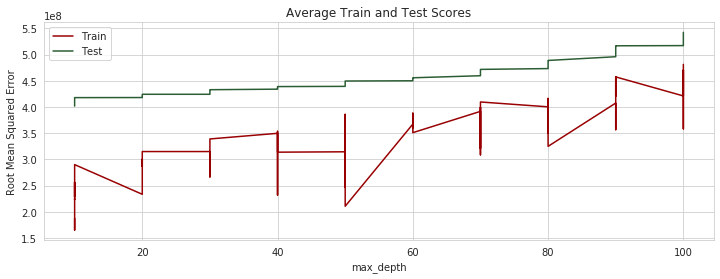

In [38]:
# plot tuning parameter
plot_results_param('max_depth', results_1)

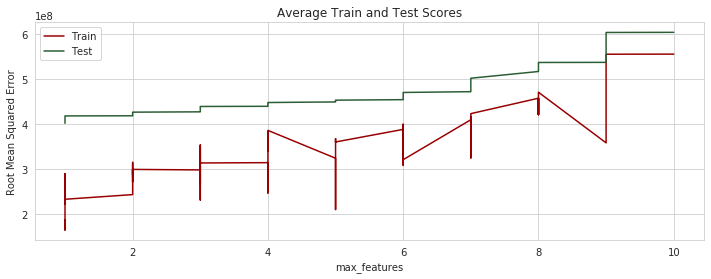

In [39]:
# plot tuning parameter
plot_results_param('max_features', results_1)

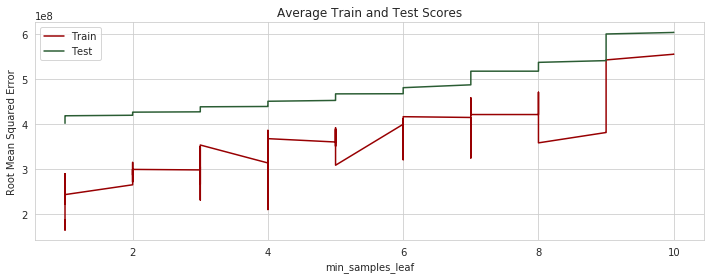

In [37]:
# plot tuning parameter
plot_results_param('min_samples_leaf', results_1)

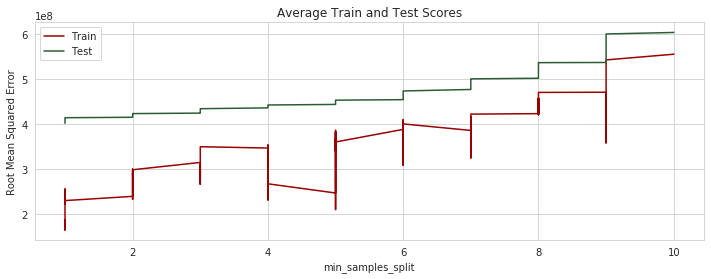

In [41]:
# plot tuning parameter
plot_results_param('min_samples_split', results_1)

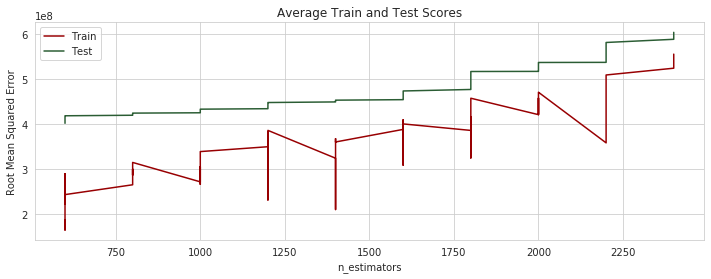

In [35]:
# plot tuning parameter
plot_results_param('n_estimators', results_1)